In [1]:
# import things

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.checkpoint import checkpoint
import numpy as np
import hexagdly
import matplotlib.pyplot as plt
import os

import sys
import paths
ThisPath  =  '/remote/tychodata/ftairli/work/Projects/FD_Reconstruction/Code/'
Paths = paths.load_ProjectPaths(ThisPath)
# add code path into the path
sys.path.append(Paths.code_path)
import ManageData as MD

import matplotlib.pyplot as plt

In [263]:
# Load Data 
Main        = torch.load(Paths.NormData + 'Main_train.pt')
GenGeometry = torch.load(Paths.NormData + 'GenGeometry_train.pt')
Meta        = torch.load(Paths.NormData + 'Meta_train.pt')
RecGeometry = torch.load(Paths.NormData + 'RecGeometry_train.pt')
# cut = (GenGeometry[:,4] < np.pi/2+0.2) * (GenGeometry[:,4] > np.pi/2-0.2)
cut = (GenGeometry[:,4] < 10*99) 

Main = Main[cut]
GenGeometry = GenGeometry[cut]
Meta = Meta[cut]
RecGeometry = RecGeometry[cut]

infs_mask = torch.isinf(Main)
print('Found {} Infs in Main'.format(infs_mask.sum()))
Main[infs_mask] = 0

# print(Main.shape)

Found 60792 Infs in Main


In [262]:
# Load Data from a particular file
Main        = torch.load(Paths.RawData + 'Main_test.pt')
GenGeometry = torch.load(Paths.RawData + 'GenGeometry_test.pt')
Meta        = torch.load(Paths.RawData + 'Meta_test.pt')
RecGeometry = torch.load(Paths.RawData + 'RecGeometry_test.pt')
cut = (GenGeometry[:,4] < 10*99) 

Main = Main[cut]
GenGeometry = GenGeometry[cut]
Meta = Meta[cut]
RecGeometry = RecGeometry[cut]

infs_mask = torch.isinf(Main)
print('Found {} Infs in Main'.format(infs_mask.sum()))
Main[infs_mask] = 0

# print(Main.shape)

Found 2509 Infs in Main


In [196]:
# Mirror Plotting Function
import matplotlib.path as mpath
import matplotlib.transforms as mtransforms
import matplotlib.pyplot as plt
import numpy as np

trans = mtransforms.Affine2D().rotate_deg(0)
hexagon_marker = mpath.Path.unit_regular_polygon(6)
hexagon_marker = hexagon_marker.transformed(trans)

def plot_mirror(Array,Mask = None):
    assert Array.shape == (2,22,20), 'Array shape is {}'.format(Array.shape)
    array1 = Array[0,...]
    array2 = Array[1,...]
    if Mask is None:
        Mask = (array1 != 0) & (array2 != 0)
    # Define offsets for odd and even rows
    Xpos_even = np.linspace(-15.75,14.75,20)
    Xpos_odd  = np.linspace(-14.75,15.75,20)
    Ypos = np.linspace(30.4,1.6,22)

    color_map = plt.get_cmap('viridis')
    colors1 = color_map(Array[0,...].flatten()).reshape(22,20,4)
    colors2 = color_map(Array[1,...].flatten()).reshape(22,20,4)

    fig, axs = plt.subplots(1,2,figsize=(20,10))
    for ax, array, colors, title in zip(axs, [array1, array2], [colors1, colors2], ['Arrival Time','Signal']):
        for i in range(22):
            for j in range(20):
                color = 'gray' if Mask[i, j] == 0 else colors[i,j]
                if i % 2 == 0:
                    ax.scatter(Xpos_even[j],Ypos[i],s=500,edgecolors='k',color=color,marker = hexagon_marker)
                else:
                    ax.scatter(Xpos_odd[j] ,Ypos[i],s=500,edgecolors='k',color=color,marker = hexagon_marker)

        ax.invert_xaxis()
        # ax.axis('off')
        ax.set_aspect('equal') 
        ax.set_title(title)
        ax.set_ylim(0,32)
        fig.colorbar(mappable=plt.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(np.min(array[Mask]), np.max(array[Mask]))), ax=ax, shrink=0.7)
    # plt.show()
    return fig, axs





In [197]:
# Some Definitions of pix Dicts
def Find_Pixel_Id(Pixel_Pos_Dict,Pixel_Pos):


    '''
    Returns the Pixel_Id for a given Pixel_Position
    '''

    for key in Pixel_Pos_Dict:
        if Pixel_Pos_Dict[key] == Pixel_Pos:
            return key

    return -1

def Get_Pixel_Pos_Dict_EBStyle():

    '''
    Returns the Pixel_Id to Pixel_Position Dictionary for the
    EventBrowser Style :
    The bottom left pixel is the first pixel in the array.
    Increases up first, then right.
    The array has 22 rows and 20 columns for each mirror
    '''

    Pixel_Pos_Dict = {}
    
    for i in range(22):
        for j in range(20):
            Pixel_Pos_Dict[22*j+i+1] = [21-i,j]

    return Pixel_Pos_Dict

Dictionary = Get_Pixel_Pos_Dict_EBStyle()

Find_Pixel_Id(Dictionary,[21,0])

1

4765
Phi       : -166.7819061279297
Theta     : 64.995361328125
Mirror Id : 4.0
MirrorOfst: 105.0
MirrorPhi : -1.7819074392318726
NetPhi    : -0.031095141544938087
15*NetPhi : -0.46642711758613586
NetTheta  : 0.42269161343574524
LogE      : 19.944049835205078
Xmax      : 820.404541015625
Zenith    : 31.5312557220459
EyeId     : 2.0


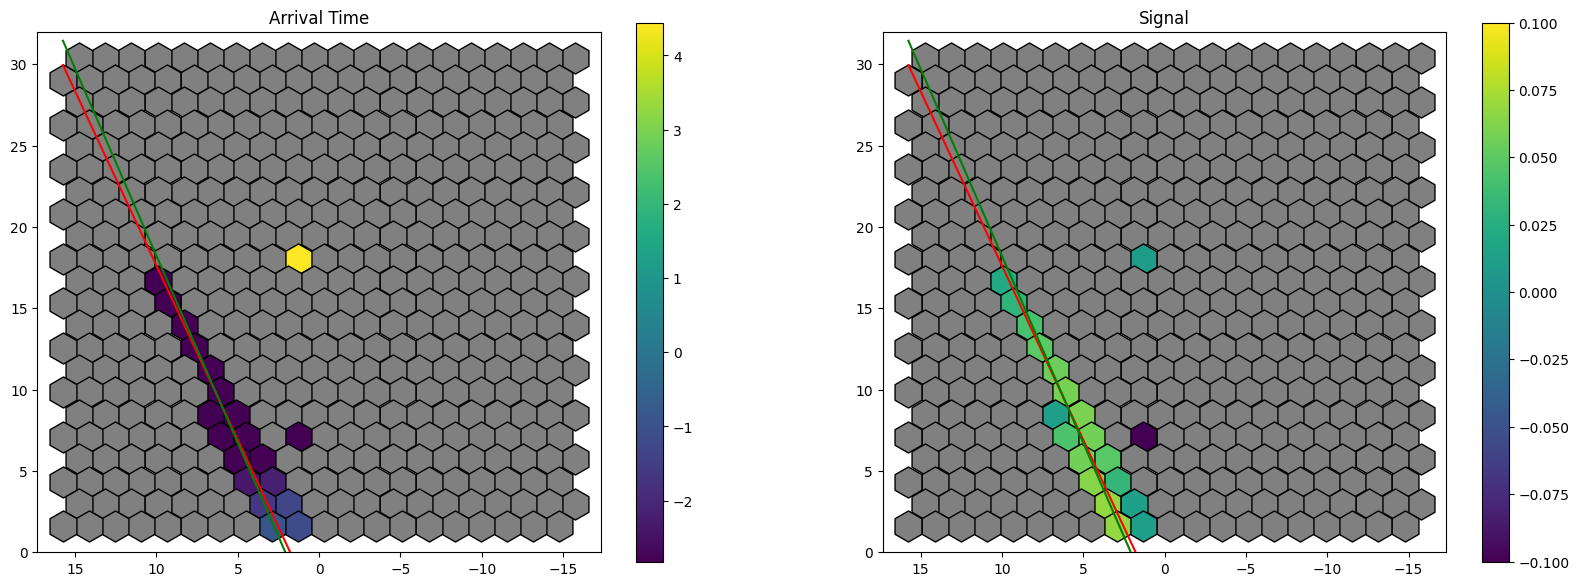

In [251]:
# Plotting For Sanity Checks
i = np.random.randint(0,Main.shape[0])
# i = 134361
# i = 88657
print(i)
print(f'Phi       : {GenGeometry[i,3]/np.pi*180}')
print(f'Theta     : {GenGeometry[i,4]/np.pi*180}')
print(f'Mirror Id : {Meta[i,9]}')
print(f'MirrorOfst: {MD.Phi_Offset_by_Mirror(Meta[i,9])*180/np.pi}')
print(f'MirrorPhi : {MD.Phi_to_mirror(GenGeometry[i,3],Meta[i,9])/np.pi*180}')

print(f'NetPhi    : {MD.Phi_to_net(MD.Phi_to_mirror(GenGeometry[i,3],Meta[i,9]))}')
print(f'15*NetPhi : {MD.Phi_to_net(MD.Phi_to_mirror(GenGeometry[i,3],Meta[i,9]))*15}')
print(f'NetTheta  : {MD.Theta_to_net(GenGeometry[i,4])}')

print(f'LogE      : {Meta[i,0]}')
print(f'Xmax      : {Meta[i,1]}')
print(f'Zenith    : {np.arccos(Meta[i,4])*180/np.pi}')
print(f'EyeId     : {Meta[i,8]}')
      
Event = Main[i,:,:,:].numpy().copy()
Event[0,...] = MD.PixTime_to_net(Event[0,...])
Event[1,...] = MD.PixSig_to_net(Event[1,...])
# print(Event[0,21,1])
fig,axs = plot_mirror(Event)
slope = np.tan(GenGeometry[i,4])
xIntercept = -MD.Phi_to_mirror(GenGeometry[i,3],Meta[i,9])/np.pi*180
offset = 0
yIntercept = -slope*(xIntercept+offset)

x = np.linspace(-15.75,15.75,200)
y = slope*x + yIntercept
axs[0].plot(x,y,'r')
axs[1].plot(x,y,'r')

slope = np.tan(RecGeometry[i,4])
xIntercept = -MD.Phi_to_mirror(RecGeometry[i,3],Meta[i,9])/np.pi*180
offset = 0
yIntercept = -slope*(xIntercept+offset)

x = np.linspace(-15.75,15.75,200)
y = slope*x + yIntercept
axs[0].plot(x,y,'g')
axs[1].plot(x,y,'g')

plt.show()
# fig,ax = plt.subplots()
# ax.imshow(MD.PixSig_to_net(Main[i,1,:,:].numpy()))
# ax.invert_yaxis()
# ax.invert_xaxis()


In [265]:
# Normalise Data
Main[:,0,:,:] = MD.PixTime_to_net(Main[:,0,:,:])
Main[:,1,:,:] = MD. PixSig_to_net(Main[:,1,:,:])
Theta         = MD.Theta_to_net(GenGeometry[:,4]).unsqueeze(1)
Phi           = MD.Phi_to_mirror(GenGeometry[:,3],Meta[:,9]).unsqueeze(1)
Phi           = MD.Phi_to_net(Phi)
Truth         = torch.cat((Theta,Phi),dim=1)
# X = torch.cos(GenGeometry[:,4]).unsqueeze(1)
# Y = torch.sin(GenGeometry[:,4]).unsqueeze(1)
# Truth         = torch.cat((X,Y),dim=1)
print(f'Truth Shape : {Truth.shape}')

# Clean Data of nans and infs
# Main_Mask  = torch.isfinite(Main)
# Main[~Main_Mask] = 0.0

Theta_Mask = torch.isfinite(Theta.sum(dim=(1)))
Phi_mask   = torch.isfinite(Phi.sum(dim=(1)))
Comb_Mask  = Theta_Mask & Phi_mask

# X_Mask = torch.isfinite(Truth[:,0])
# Y_Mask = torch.isfinite(Truth[:,1])
# Comb_Mask = X_Mask & Y_Mask
print('Unclean Size = {}'.format(len(Truth) - Comb_Mask.sum()))
CleanMain  = Main[Comb_Mask]
CleanTruth = Truth[Comb_Mask]

print(f'Truth Shape : {CleanTruth.shape}')   

Truth Shape : torch.Size([141787, 2])
Unclean Size = 0
Truth Shape : torch.Size([141787, 2])


In [266]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, Main, Truth):
        self.Main = Main
        self.Truth = Truth
    def __len__(self):
        return len(self.Main)
    def __getitem__(self, idx):
        return self.Main[idx,:,:,:], self.Truth[idx,:]
    
Data = MyDataset(CleanMain,CleanTruth)

In [267]:
def Loss(Pred,Truth,which = 'Both'):
    if which =='Both':
        criterion = nn.MSELoss()
        return criterion(Pred,Truth)
    elif which == 'Theta':
        criterion = nn.MSELoss()
        return criterion(Pred[:,0],Truth[:,0])
    elif which == 'Phi':
        criterion = nn.MSELoss()
        return criterion(Pred[:,1],Truth[:,1])
    elif which == 'XY':
        criterion = nn.MSELoss()
        return criterion(Pred,Truth)
    else:
        print('Error: Loss not defined')
        return 0.0

In [225]:
class ModelXY(nn.Module):
    def __init__(self):
        super(ModelXY, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 5, stride = 1 ,padding=(1,2)) # Should Return a 20x20 with this padding
        self.conv2 = nn.Conv2d(32, 32, 5, stride = 1 ,padding=2) # Should Return a 20x20 with this padding
        self.AvPool= nn.AvgPool2d(2, stride=2) # Should Return a 10x10
        self.conv3 = nn.Conv2d(32,32,3,stride=1,padding=1) # Should Return a 10x10

        self.Dense1 = nn.Linear(32*100, 32*2)
        self.Dense2 = nn.Linear(32*2, 32*2)
        self.Dense3 = nn.Linear(32*2, 2)

        self.Activation = nn.ReLU()
        self.FinalActivation = nn.Tanh()
        # Weight Initialization

    def forward(self, x):
        x = self.Activation(self.conv1(x))
        x = self.Activation(self.conv2(x))
        x = self.AvPool(x)
        x = self.Activation(self.conv3(x))

        # Reshape

        x = x.view(-1, 32*100)        
        
        x = self.Activation(self.Dense1(x))
        x = self.Activation(self.Dense2(x))
        x = self.FinalActivation(self.Dense3(x))
        return x
        
        

In [277]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, 5, stride = 1 ,padding=(1,2)) # Should Return a 20x20 with this padding
        self.conv2 = nn.Conv2d(32, 32, 5, stride = 1 ,padding=2) # Should Return a 20x20 with this padding
        self.conv3 = nn.Conv2d(32,32,3,stride=1,padding=1) # Should Return a 20x20 with this padding

        self.Dense1 = nn.Linear(32*400, 32*2)
        self.Dense2 = nn.Linear(32*2, 32*2)
        self.Dense3 = nn.Linear(32*2, 2)

        self.Activation = nn.ReLU()


    def forward(self, x):
        x = self.Activation(self.conv1(x))
        x = self.Activation(self.conv2(x))
        x = self.Activation(self.conv3(x))

        # Reshape
        x = x.view(-1, 32*400)

        x = self.Activation(self.Dense1(x))
        x = self.Activation(self.Dense2(x))
        x = self.Dense3(x)

        return x
        # return torch.cat((Theta,Phi),dim=1)
        

In [291]:
class Model_1_0(nn.Module):

    def __init__(self,in_channels = 2,N_filters = 32,NDenseNodes = 128,Dtype=torch.float32):
        assert N_filters % 4 ==0 , 'N_filters must be a multiple of 4'
        assert NDenseNodes % 2 ==0 , 'NDenseNodes must be a multiple of 2'

        super(Model_1_0, self).__init__()
        # Info
        self.Name = 'Model_1_0'
        self.Description = '''
        Try to predict the SDP, 
        two parameters: Phi and Theta
        Introduce the normalisation state variable to keep track of the normalisation state and adjust on the fly if needed
        '''
        # Layers
        # Initial Scan by these layers (Add more later, maybe)
        self.Scan1 = nn.Conv2d(in_channels=in_channels, out_channels=N_filters, kernel_size=5, stride=1, padding=(1,2),dtype=Dtype) # Outputs 20x20
        
        self.conv1 = nn.Conv2d(in_channels=N_filters, out_channels=N_filters, kernel_size=3, stride=1, padding=(1,1),dtype=Dtype) # Outputs 20x20
        self.conv2 = nn.Conv2d(in_channels=N_filters, out_channels=N_filters, kernel_size=3, stride=1, padding=(1,1),dtype=Dtype) # Outputs 20x20
        self.conv3 = nn.Conv2d(in_channels=N_filters, out_channels=N_filters, kernel_size=3, stride=1, padding=(1,1),dtype=Dtype) # Outputs 20x20

        # Dense Layers for prediction
        self.PhiDense1 = nn.Linear(20*20*N_filters,NDenseNodes,dtype=Dtype)
        self.PhiDense2 = nn.Linear(NDenseNodes,NDenseNodes,dtype=Dtype)
        self.PhiDense3 = nn.Linear(NDenseNodes,1,dtype=Dtype)

        self.ThetaDense1 = nn.Linear(20*20*N_filters,NDenseNodes,dtype=Dtype)
        self.ThetaDense2 = nn.Linear(NDenseNodes,NDenseNodes,dtype=Dtype)
        self.ThetaDense3 = nn.Linear(NDenseNodes,1,dtype=Dtype)

        self.ConvActivation   = nn.LeakyReLU()
        self.DenseActivation  = nn.LeakyReLU()
        
        
        # Initialize weights
        nn.init.kaiming_normal_(self.Scan1.weight, nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.conv3.weight, nonlinearity='leaky_relu')
        

        nn.init.kaiming_normal_(self.PhiDense1.weight, nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.PhiDense2.weight, nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.PhiDense3.weight, nonlinearity='leaky_relu')

        nn.init.kaiming_normal_(self.ThetaDense1.weight, nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.ThetaDense2.weight, nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.ThetaDense3.weight, nonlinearity='leaky_relu')


    def forward(self, Main):
        # Scan
        out = self.ConvActivation(self.Scan1(Main))
        # Conv
        out = self.ConvActivation(self.conv1(out))
        out = self.ConvActivation(self.conv2(out))
        out = self.ConvActivation(self.conv3(out))
        # Flatten
        out = out.view(out.shape[0],-1)
        # Predict
        Phi = self.DenseActivation(self.PhiDense1(out))
        Phi = self.DenseActivation(self.PhiDense2(Phi))
        Phi = self.PhiDense3(Phi)
        # Phi = Phi*0
        Theta = self.DenseActivation(self.ThetaDense1(out))
        Theta = self.DenseActivation(self.ThetaDense2(Theta))
        Theta = self.ThetaDense3(Theta)

        return torch.cat((Phi,Theta),dim=1)



In [292]:
torch.autograd.set_detect_anomaly(True)

In [303]:
device  = 'cuda'
model = Model_1_0().to(device)
LR = 0.001
optimizer = optim.Adam(model.parameters(), lr=LR)
BatchSize = 32
Losses = []
dataloader = torch.utils.data.DataLoader(Data, batch_size=BatchSize, shuffle=True)
totalEpochs = 0

Finished Epoch with Loss = 0.01866741720364221
Total Epochs: 7


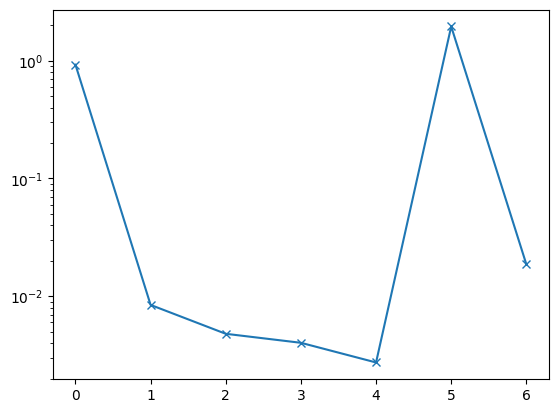

In [316]:
model.train()
batchN = 0
total_loss = 0
for BatchMain,BatchTruth in dataloader:
    BatchMain = BatchMain.to(device)
    BatchTruth = BatchTruth.to(device)
    optimizer.zero_grad()
    Pred = model(BatchMain)
    # print(Pred.mean(dim=0),Pred.std(dim=0))
    # plt.hist(Pred[:,0].cpu().detach().numpy(),bins=100,range = [-1,1],label='Phi')
    # plt.hist(Pred[:,1].cpu().detach().numpy(),bins=100,range = [-1,1],label='Theta')
    # plt.legend()
    # plt.show()
    loss = Loss(Pred,BatchTruth,which='Both')
    print(f'Batch: {batchN}, Loss : {loss.item()}',end='\r')
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    batchN += 1
totalEpochs+=1

total_loss /= len(dataloader)
Losses.append(total_loss)
print(f'Finished Epoch with Loss = {total_loss}')
print(f'Total Epochs: {totalEpochs}')
torch.cuda.empty_cache()
plt.figure()
plt.plot(Losses,marker = 'x')
plt.yscale('log')

In [317]:
model.eval()
preds = model(CleanMain[0:10000,...].to(device)).detach().cpu().numpy()
truth = CleanTruth[0:10000,...].detach().cpu().numpy()


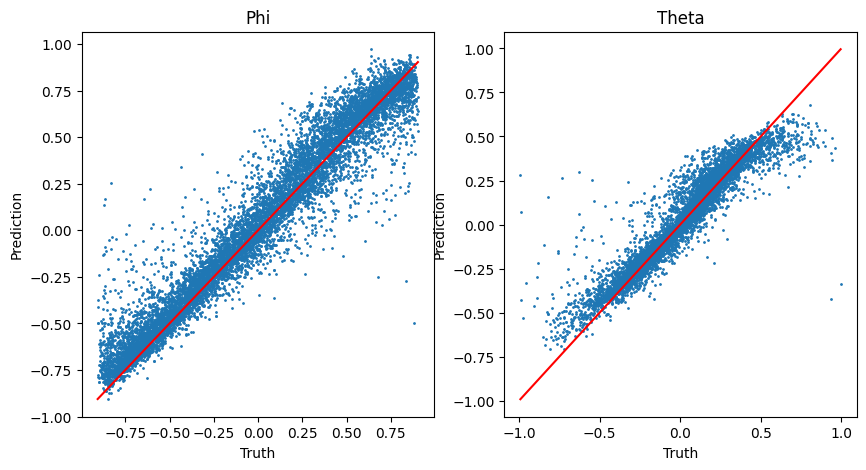

In [318]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(truth[:,0],preds[:,0],s=1)
ax[0].plot([min(truth[:,0]),max(truth[:,0])],[min(truth[:,0]),max(truth[:,0])],'r')
ax[0].set_xlabel('Truth')
ax[0].set_ylabel('Prediction')
ax[0].set_title('Phi')
ax[1].scatter(truth[:,1],preds[:,1],s=1)
ax[1].plot([min(truth[:,1]),max(truth[:,1])],[min(truth[:,1]),max(truth[:,1])],'r')
ax[1].set_xlabel('Truth')
ax[1].set_ylabel('Prediction')
ax[1].set_title('Theta')
plt.show()